In [19]:
'''
Things to do:
1. use multiple frames to predict next frame.
2. Test different sample frequencies.
'''

import os
import imageio
import sys
# you might want to run this if you don't have ffmpeg installed
# imageio.plugins.ffmpeg.download()

context = {}
context['home'] = os.getcwd()
context['fname_input'] = 'test_avi/test.mp4'
# current analysis must be done with 2.0 or 5.0 fps
context['frate'] = 2.0
assert context['frate'] in (2.0, 5.0)


def read_video(fname_input, frate=2.0):
    global context
    home = context['home']
    fname_full = os.path.join(home, fname_input)
    vid = imageio.get_reader(fname_full, 'ffmpeg')
    vid_info = vid.get_meta_data()
    
    context['s_hz'] = vid_info['fps']
    s_length = vid_info['duration']
    context['s_length'] = s_length

    min_duration = 1.0 / frate
    if s_length < min_duration:
        msg = 'The length of this video ({0}s) is smaller than the minimum duration ({1}s).'\
            .format(s_length, min_duration)
        raise ValueError(msg)
    else:
        return vid

vid = read_video(context['fname_input'], context['frate'])

In [20]:
# This takes the frames of the avi and converts them into the .hkl files
# The script is based on process_kitti

import numpy as np
from scipy.misc import imread, imresize
import hickle as hkl
import pandas as pd


def process_im(im, desired_sz):
    '''
    resize and crop image
    params: im - an image represented in a 5d array
            desired_sz - a tuple of width and height
    returns: a transformed image
    '''
    target_ds = float(desired_sz[0])/im.shape[0]
    im = imresize(im, (desired_sz[0], int(np.round(target_ds * im.shape[1]))))
    d = (im.shape[1] - desired_sz[1]) / 2
    im = im[:, d:d + desired_sz[1]]
    return im


def convert_video_to_hkl(vid, fname_input, desired_im_sz=(128, 160)):
    
    # set the params
    global context
    frate = context['frate']
    s_hz = context['s_hz']
    s_length = context['s_length']
    
    frames_per_clip = 10
    context['frames_per_clip'] = frames_per_clip
    max_clip = 1000 # limit of clips for a part
    split = 'test'

    # step_im
    s_num_frames = int(round(s_hz * s_length))
    s_orig_ms_per_frame = 1000 / s_hz
    s_targ_ms_per_frame = 1000.0 / frate
    context['s_orig_ms_per_frame'] = s_orig_ms_per_frame

    # skip: step of the sampling method
    skip = round(s_targ_ms_per_frame / s_orig_ms_per_frame)
    context['skip'] = skip

    s_actual_hz = s_hz / skip
    s_actual_ms_per_frame = 1000 / s_actual_hz
    s_total_clips = int(s_num_frames / (frames_per_clip * skip))

    # parts: each part contains no more than <max_clip> number of clips
    parts = int(s_total_clips / max_clip) + 1
    context['parts'] = parts
    step_im = max_clip * frames_per_clip
    suffix = '_P' + str(parts) + '_'
    context['suffix'] = suffix

    # num_im: total number of images sampled
    num_im = s_total_clips * frames_per_clip 

    # initialize the test data
    X = np.zeros((num_im,) + desired_im_sz + (3,), np.uint8)
    # source in each frame makes sure each clip has frames in the same video
    source_list = [fname_input] * num_im

    # sample the images from vid
    ct = 0
    for i, im_out in enumerate(vid):
        if i % skip == 0:
            im = vid.get_data(i)
            X[ct] = process_im(im, desired_im_sz)
            ct = ct + 1
            if ct == num_im:
                break

    # store the images and sources into repective hickle file
    home = context['home']
    if not (os.path.isdir(home + "/test_avi")):
        os.mkdir(home + '/test_avi')
    else:
        for temp in os.listdir(home + '/test_avi'):
            if temp[-4:] == '.hkl':
                os.remove(os.path.join(home, 'test_avi', temp))

    for part in range(1, parts + 1):
        xbeg = int((part - 1) * step_im)
        if (part == parts):
            xend = num_im    
        else:
            xend = int(part * step_im) 
        print 'Test data has {0} part(s), starts at image {1} and ends at image {2}.'.format(part,xbeg,xend)
        hkl.dump(X[xbeg:xend], os.path.join(home, 'test_avi', 'X_' + split + suffix+ str(part)+'.hkl'))
        hkl.dump(source_list[xbeg:xend], os.path.join(home, 'test_avi', 'sources_' + split + suffix + str(part)+ '.hkl'))
    

convert_video_to_hkl(vid, context['fname_input'], desired_im_sz=(128, 160))

Test data has 1 part(s), starts at image 0 and ends at image 210.


In [21]:
'''
Evaluate trained PredNet on test video.
Calculates mean-squared error
'''

from six.moves import cPickle
from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten

PREDNET_PATH = '../models/prednet'
sys.path.append(PREDNET_PATH)
from prednet import PredNet
from data_utils import SequenceGenerator

DATA_DIR = './test_avi/'
WEIGHTS_DIR = os.path.join(PREDNET_PATH, 'model_data')
RESULTS_DIR = './test_results_avi/'

# these are set in the cell above, uncomment this and this cell should
# work for avi's less than 1000 frames (1000 clips at 10 frames/clip)
# This would be 500 sec at 2Hz or 200 sec at 5Hz 
# parts = 1
# suffix = '_P1_'

def assemble_model():

    global context
    batch_size = 10
    context['batch_size'] = batch_size
    nt = 10  # number of frames per clip
    context['nt'] = nt
    # prednet used KITTI dataset that has 10 frames per clip, which is changable

    fpath_weights = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')
    fpath_json = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

    # Load trained model
    with open(fpath_json, 'r') as fj:
        json_string = fj.read()
    trained_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
    trained_model.load_weights(fpath_weights)

    # get configs from the trained model
    layer_config = trained_model.layers[1].get_config()
    layer_config['output_mode'] = 'prediction'
    dim_ordering = layer_config['dim_ordering']
    context['dim_ordering'] = dim_ordering

    # assemble test model (to output predictions) 
    '''what does this means? only using one layer'''
    test_prednet = PredNet(weights=trained_model.layers[1].get_weights(), **layer_config)
    input_shape = list(trained_model.layers[0].batch_input_shape[1:])
    input_shape[0] = nt
    inputs = Input(shape=tuple(input_shape))
    predictions = test_prednet(inputs)
    test_model = Model(input=inputs, output=predictions)
    
    return test_model

In [22]:
def predict_and_evaluate(test_model):
    global context
    batch_size = context['batch_size']
    nt = context['nt']
    dim_ordering = context['dim_ordering']
    
    if not os.path.exists(RESULTS_DIR): 
        os.mkdir(RESULTS_DIR)

    parts = context['parts']
    for part in range(1, parts+1):
        suffix = context['suffix']
        curr_test = 'X_test' + suffix + str(part) + '.hkl'
        curr_sources = 'sources_test' + suffix + str(part) + '.hkl'
        test_file = os.path.join(DATA_DIR, curr_test)
        test_sources = os.path.join(DATA_DIR, curr_sources)

        # generate inputs from the test hickle file
        test_generator = SequenceGenerator(test_file, test_sources, nt,\
                                           sequence_start_mode='unique', dim_ordering=dim_ordering)

        # final X_test.shape = (26, 10, 128, 160, 3)
        X_test = test_generator.create_all()
        X_hat = test_model.predict(X_test, batch_size)
        if dim_ordering == 'th':
            X_test = np.transpose(X_test, (0, 1, 3, 4, 2))
            X_hat = np.transpose(X_hat, (0, 1, 3, 4, 2))

        curr_mse_frame2 = 'mse_frame2' + suffix + str(part) + '.csv'
        mse_frame2_out = os.path.join(RESULTS_DIR, curr_mse_frame2)

        # [2, 3, 4] is the x, y, grb
        mse_point = (X_test - X_hat) ** 2
        mse_point[:, :2] = 0  # the errors of first two frames not helpful
        mse_frame2 = np.squeeze(np.apply_over_axes(np.mean, mse_point, [2,3,4]))
        np.savetxt(mse_frame2_out, mse_frame2, delimiter=",")

        print 'mse_frame2'
        print type(mse_frame2)
        print mse_frame2.shape
        print 'Errors in the first clip:'
        print mse_frame2[0, :]

    return mse_frame2

In [23]:
# get the squared error for each frame
test_model = assemble_model()
mse_frame2 = predict_and_evaluate(test_model)

mse_frame2
<type 'numpy.ndarray'>
(21, 10)
Errors in the first clip:
[ 0.          0.          0.00084366  0.00073687  0.00047403  0.00061762
  0.00046855  0.00054966  0.00029485  0.00048491]


In [25]:
def get_accidents(mse_frame2):
    '''
    '''
    global context
    frate = context['frate']
    frames_per_clip = context['frames_per_clip']
    skip = context['skip']
    s_orig_ms_per_frame = context['s_orig_ms_per_frame']
    
    # take first five seconds to calculate threshold
    sample = mse_frame2[:int(frate), 2:].reshape(1, -1)
    mean = np.mean(sample)
    stdev = np.std(sample) 

    accident_threshold = mean + 5 * stdev
    context['threshold'] = accident_threshold
    print 'Using threshold: {}.'.format(accident_threshold)
    
    accident_frames = np.where(mse_frame2 > accident_threshold, True, False)
    
    # for i, clip in enumerate(accident_frames):
    #     print i * 5, clip
    
    second_per_frame = 1 / frate
    accidents = []
    accident_in_last_clip = False
    for i, frame_arr in enumerate(accident_frames):
        if np.sum(frame_arr) > 2:
            if accident_in_last_clip:
                start = 0
            else:
                start = np.argmax(frame_arr)
            end = len(frame_arr) - 1
            while not frame_arr[end]:
                end -= 1
            accidents.append(((i * 10 + start) * second_per_frame,
                              (i * 10 + end) * second_per_frame))
            accident_in_last_clip = True
        else:
            accident_in_last_clip = False
    
    return accidents


accidents = get_accidents(mse_frame2)
for accident in accidents:
    print "An accident happened from {0}s to {1}s.".format(accident[0], accident[1])

Using threshold: 0.00121029856382.
An accident happened from 32.0s to 34.0s.
An accident happened from 35.0s to 39.5s.
An accident happened from 46.0s to 47.0s.
An accident happened from 87.5s to 88.5s.


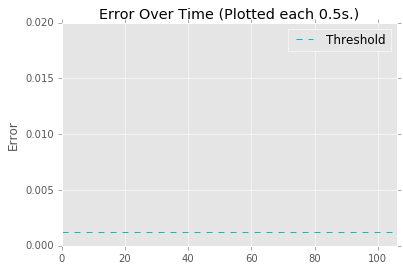

In [65]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import animation
from matplotlib import style
style.use('ggplot')


def update(i, x, y, line):
    line.set_data(x[:i], y[:i])
    line.axes.axis([0, 106, 0, 0.02])
    return line,


def plot_error(interval=500, output_video=False):
    
    global context
    threshold = context['threshold']
    s_length = context['s_length']
    
    fig = plt.figure()  # figsize=(10, 4.5), dpi=80)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Error Over Time (Plotted each 0.5s.)')
    ax.set_xlim(0, s_length)
    # ax.set_xlabel('Time (s)', ha='right')
    ax.set_ylabel('Error')
    
    plt.plot([0, s_length], [threshold, threshold], '--c', label='Threshold')
    plt.legend(loc='upper right')
    
    line, = ax.plot([], [])

    y = mse_frame2.reshape(1, -1)[0]
    x = np.arange(0, len(y)/2, 0.5)

    anim = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line], interval=interval, blit=False)
    if output_video:
        save_path = os.path.join('test_results_avi', 'test_error.mp4')
        anim.save(save_path)  # , writer='imagemagick')
    return anim


anim = plot_error(interval=100)

In [66]:
%matplotlib inline
HTML(anim.to_html5_video())